In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Käytä esikoulutettua mallia (esim. VGG16) piirteiden irrottamiseen
Kouluta vain oma luokittelija (fully connected) irrotettujen piirteiden päälle
Vertaa suorituskykyä ensimmäiseen malliin

In [90]:
conv_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
@tf.function(reduce_retracing=True)
def extract_features(images):
    return conv_base(images)

def get_features_and_labels(dataset):
    all_features, all_labels = [], []
    for images, labels in dataset:
        if labels is None:
            continue
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = extract_features(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return tf.concat(all_features, axis=0), tf.concat(all_labels, axis=0)

train_dataset = image_dataset_from_directory("kuvat/train", image_size=(224, 224), batch_size=32)
validation_dataset = image_dataset_from_directory("kuvat/validation", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory("kuvat/test", image_size=(224, 224), batch_size=32)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
train_features.shape

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


TensorShape([126, 7, 7, 512])

In [92]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [93]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.4883 - loss: 29.6458 - val_accuracy: 0.5556 - val_loss: 23.5594
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6940 - loss: 11.7721 - val_accuracy: 0.5185 - val_loss: 19.8942
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8123 - loss: 6.3766 - val_accuracy: 0.5556 - val_loss: 18.7694
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.9359 - loss: 0.8729 - val_accuracy: 0.5185 - val_loss: 17.5283
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8837 - loss: 1.5021 - val_accuracy: 0.5556 - val_loss: 11.4881
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9676 - loss: 0.9589 - val_accuracy: 0.5926 - val_loss: 8.3190
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9832 - loss: 0.1299 - val_accuracy: 0.6296 - val_loss: 7.2680
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9549 - loss: 0.1627 - val_accuracy: 0.7037 - va

In [95]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9630 - loss: 0.1099
Test accuracy: 0.963


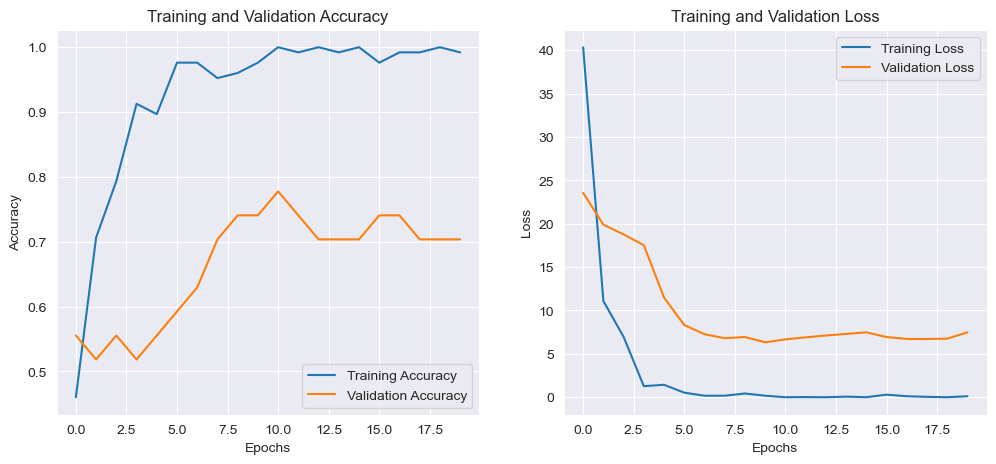

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
              precision    recall  f1-score   support

    haarukka       1.00      0.89      0.94         9
     lusikka       1.00      1.00      1.00         9
      veitsi       0.90      1.00      0.95         9

    accuracy                           0.96        27
   macro avg       0.97      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



In [96]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict(test_features), axis=1)
print(classification_report(test_labels, y_pred, target_names=['haarukka', 'lusikka', 'veitsi']))


Found 27 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


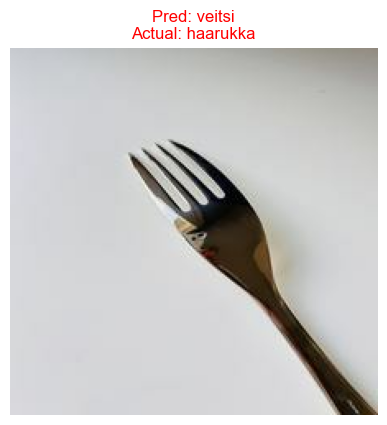